# Step 1 Prepare Road Network

In [1]:
import osmnx as ox
road_file = 'porto.graphml'
road_folder = 'D:/MapMatchingPython/data/osm/porto_road'

road_graph = ox.load_graphml(filename=road_file, folder=road_folder)
road_graph_utm = ox.project_graph(road_graph)

### 1.1 Extract Edge Data from Road Network

In [2]:
def road_graph_to_edge_gpd(road_graph):
    '''
    store road segments into a geppandas dataframe
    :param road_graph: a road network graph in networkx
    :return gpd_edges: a geopandas dataframe of road segments
    '''
    from shapely.geometry import Point, LineString
    import geopandas as gpd
    #froms = []
    #tos = []
    #geometries = []
    gpd_edges = gpd.GeoDataFrame(columns=('from','to','geometry','length','highway'))
    for e_from, e_to, data in road_graph.edges(data=True):
        #froms.append(e_from)
        #tos.append(e_to)
        if 'geometry' in data:
            #geometries.append(data['geometry'])
            s = gpd.GeoSeries({'from':e_from, 
                               'to':e_to, 
                               'geometry':data['geometry'], 
                               'length':data['length'],
                               'highway':data['highway']})
            gpd_edges = gpd_edges.append(s, ignore_index=True)
        else:
            p1 = Point(road_graph.nodes[e_from]['x'], road_graph.nodes[e_from]['y'])
            p2 = Point(road_graph.nodes[e_to]['x'], road_graph.nodes[e_to]['y'])
            #geometries.append(LineString((p1, p2)))
            data.update({'geometry':LineString((p1, p2))})
            s = gpd.GeoSeries({'from':e_from, 
                               'to':e_to, 
                               'geometry':LineString((p1, p2)), 
                               'length':data['length'],
                               'highway':data['highway']})
            gpd_edges = gpd_edges.append(s, ignore_index=True)

    #gpd_edges = gpd.GeoDataFrame(data={'from': froms, 'to': tos, 'geometry': geometries})
    gpd_edges.crs = road_graph.graph['crs']
    gpd_edges.name = 'edges'
    # create bounding box for each edge geometry
    gpd_edges['bbox'] = gpd_edges.apply(lambda row: row['geometry'].bounds, axis=1)
    return gpd_edges

gpd_edges_utm = road_graph_to_edge_gpd(road_graph_utm)
gpd_edges_utm.head()

,from,to,geometry,length,highway,bbox
0,296058885,1628753289,LINESTRING (531068.006566746 4558739.619749674...,155.377405,secondary,"(531068.006567, 4558592.64786, 531117.808982, ..."
1,296058885,1561621045,LINESTRING (531068.006566746 4558739.619749674...,67.837805,primary,"(531068.006567, 4558739.61975, 531135.491049, ..."
2,2185756687,435240914,LINESTRING (533863.3661556013 4558657.15794647...,260.154858,"[residential, service]","(533676.804891, 4558563.44126, 533863.366156, ..."
3,2185756687,506111741,LINESTRING (533863.3661556013 4558657.15794647...,175.753043,service,"(533863.366156, 4558641.90652, 534038.822479, ..."
4,299597866,299598639,LINESTRING (534689.3168561951 4558013.88137999...,54.764152,residential,"(534689.316856, 4558013.88138, 534723.50894, 4..."


### 1.2 Add max speed information

In [3]:
def get_max_speed(highway):
    '''
    return the corresponding max speed in kmph 
    '''
    if highway == 'mortorway':
        return 100
    elif highway == 'mortorway_link':
        return 60
    elif highway == 'trunk':
        return 80
    elif highway == 'trunk_link':
        return 40
    elif highway == 'primary':
        return 60
    elif highway == 'primary_link':
        return 40
    elif highway == 'secondary':
        return 50
    elif highway == 'secondary_link':
        return 20
    elif highway == 'residential':
        return 30
    elif highway == 'teritiary':
        return 50
    elif highway == 'teritiary_link':
        return 20
    elif highway == 'living_street':
        return 20
    elif highway == 'road':
        return 20
    elif highway == 'service':
        return 20
    else:
        return 50
        
    
def get_max_speeds(gpd_edges_utm):
    max_speeds = []
    for idx, row in gpd_edges_utm.iterrows():
        if isinstance(row['highway'], list):
            max_speed1 = get_max_speed(row['highway'][0])
            max_speed2 = get_max_speed(row['highway'][1])
            if row['length'] > 100:
                max_speed = max(max_speed1, max_speed2)
                max_speeds.append(max_speed)
            else:
                max_speed = min(max_speed1, max_speed2)
                max_speeds.append(max_speed)
        else:
            max_speeds.append(get_max_speed(row['highway']))
    return max_speeds


max_speeds = get_max_speeds(gpd_edges_utm)
gpd_edges_utm['max speed'] = max_speeds
gpd_edges_utm.head()

,from,to,geometry,length,highway,bbox,max speed
0,296058885,1628753289,LINESTRING (531068.006566746 4558739.619749674...,155.377405,secondary,"(531068.006567, 4558592.64786, 531117.808982, ...",50
1,296058885,1561621045,LINESTRING (531068.006566746 4558739.619749674...,67.837805,primary,"(531068.006567, 4558739.61975, 531135.491049, ...",60
2,2185756687,435240914,LINESTRING (533863.3661556013 4558657.15794647...,260.154858,"[residential, service]","(533676.804891, 4558563.44126, 533863.366156, ...",30
3,2185756687,506111741,LINESTRING (533863.3661556013 4558657.15794647...,175.753043,service,"(533863.366156, 4558641.90652, 534038.822479, ...",20
4,299597866,299598639,LINESTRING (534689.3168561951 4558013.88137999...,54.764152,residential,"(534689.316856, 4558013.88138, 534723.50894, 4...",30


# Step2: Load Trajectory

In [4]:
def read_trip(filename):
    '''
    read trajectory from csv file
    '''
    import pandas as pd
    import geopandas as gpd
    from shapely.geometry import Point
    col_names = ['obj_id', 'lat', 'lon', 'timestamp', 'unknown1', 'unknow2']
    trip = pd.read_csv(filename, header=None, names=col_names)
    trip.drop(['unknown1', 'unknow2'], axis=1, inplace=True)
    trip['geometry'] = trip.apply(lambda z: Point(z.lon, z.lat), axis=1)
    trip = gpd.GeoDataFrame(trip)
    return trip

### coordinate transformation
def transform_coordinates(point, crs, to_crs):
    import osmnx as ox
    return ox.project_geometry(point,crs, to_crs)[0]

In [5]:
trip_folder = 'D:/MapMatchingPython/data/trips'
trip_file = trip_folder + '/trip_0.txt'
trip = read_trip(trip_file)
# coordinate transformation
crs = road_graph.graph['crs']
to_crs = road_graph_utm.graph['crs']
trip['geometry_utm'] = trip.apply(lambda row: transform_coordinates(row['geometry'], crs, to_crs), axis=1)
trip.head()

,obj_id,lat,lon,timestamp,geometry,geometry_utm
0,20000589,41.141412,-8.618643,1372636858,POINT (-8.618642999999999 41.141412),POINT (532004.0931626002 4554525.40328601)
1,20000589,41.141376,-8.618499,1372636873,POINT (-8.618499 41.141376),POINT (532016.1954063133 4554521.459764727)
2,20000589,41.142510,-8.620326,1372636888,POINT (-8.620325999999999 41.14250999999999),POINT (531862.321380579 4554646.677934005)
3,20000589,41.143815,-8.622153,1372636903,POINT (-8.622152999999999 41.143815),POINT (531708.3702606896 4554790.882491105)
4,20000589,41.144373,-8.623953,1372636918,POINT (-8.623953 41.144373),POINT (531557.0490813914 4554852.173654097)


# Step3: Query candidates

### Step3.1: Build R-tree Index for Road Network

In [6]:
def build_rtree_index_edges(gpd_edges):
    '''
    build a r-tree index for road segments
    input:
        gpd_edges: a geopandas dataframe that contains road segments (edge geometries)
    output:
        idx: a r-tree index of the edge geometries
    '''
    # r-tree index for edges
    from rtree import index
    p = index.Property()
    idx = index.Index(properties=p)
    for index, row in gpd_edges.iterrows():
        idx.insert(index, row['bbox'], obj=row)
    return idx

edge_idx = build_rtree_index_edges(gpd_edges_utm)

### Step3.2 Query

In [7]:
def query_k_nearest_road_segments(edge_idx, point, k):
    from shapely.geometry import Point, LineString
    from shapely.ops import nearest_points
    import pandas as pd
    '''
    query k-nearest road segments of a given point
    :param edge_idx: the road segments r-tree index
    :param point: the given point
    :param k: the number of segments needed to query
    :return: k candidates as a pandas DataFrame
    '''
    candidates = pd.DataFrame(columns=('distance', 'from', 'to', 'proj_point', 'road'))
    hits = edge_idx.nearest((point.x, point.y, point.x, point.y), k, objects=True)
    for item in hits:
        results = nearest_points(point, item.object['geometry'])
        d = point.distance(results[1])
        s = pd.Series({'distance':d,
                       'from':item.object['from'], 
                       'to':item.object['to'], 
                       'proj_point':results[1],
                      'road':item.object})
        candidates = candidates.append(s, ignore_index=True)
    #candidates['observation prob'] = candidates.apply(lambda row: normal_distribution())
    candidates.sort_values(by='distance', axis=0, inplace=True)
    return candidates


def find_candidates(trip, road_idx, k):
    '''
    given a trip, find candidates points for each point in the trip
    :param trip: a GPS trajectory (without coordinates transform)
    :param road_idx: road segments r-tree index of the corresponding road network
    :param k: the number of candidates
    :return: the trip with candidates
    '''
    candi_list = []
    #point_list = []
    #crs = road_graph.graph['crs']
    #to_crs = road_graph_utm.graph['crs']
    for i in range(0, len(trip)):
        #candidates = []
        #point_utm = ox.project_geometry(trip.iloc[i]['geometry'], crs=crs, to_crs=to_crs)[0]
        #point_list.append(point_utm)
        candidates = query_k_nearest_road_segments(edge_idx, trip.iloc[i]['geometry_utm'], k)
        candi_list.append(candidates)
    trip['candidates'] = candi_list
    #trip['geometry_utm'] = point_list
    #return trip

In [8]:
k = 3
find_candidates(trip, edge_idx, k)
trip.head()

,obj_id,lat,lon,timestamp,geometry,geometry_utm,candidates
0,20000589,41.141412,-8.618643,1372636858,POINT (-8.618642999999999 41.141412),POINT (532004.0931626002 4554525.40328601),distance from to \ 0 4....
1,20000589,41.141376,-8.618499,1372636873,POINT (-8.618499 41.141376),POINT (532016.1954063133 4554521.459764727),distance from to \ 0 2....
2,20000589,41.142510,-8.620326,1372636888,POINT (-8.620325999999999 41.14250999999999),POINT (531862.321380579 4554646.677934005),distance from to \ 0 3....
3,20000589,41.143815,-8.622153,1372636903,POINT (-8.622152999999999 41.143815),POINT (531708.3702606896 4554790.882491105),distance from to \ 0 0....
4,20000589,41.144373,-8.623953,1372636918,POINT (-8.623953 41.144373),POINT (531557.0490813914 4554852.173654097),distance from to \ 0 0.86...


# Step 4: HMM based Map Matching

### Step 4.1 Measurement Probabilities

In [9]:
def normal_distribution(mu, sigma, x):
    '''
    calculate normal distribution values
    input:
    mu: the mean value
    sigma; the standard deviation
    x: the given variables
    output:
    the probabilities of given input variables x
    '''
    import numpy as np
    return 1.0/(sigma * np.sqrt(2*np.pi)) * ( np.exp(-1.0 * (np.array(x)-mu)**2 / (2 * sigma**2)) )

#x = [10,20,30,40,50]
#mu = 0
#sigma = 20
#normal_distribution(mu,sigma,x)
def calculate_observation_probability(trip, mu, sigma):
    for i in range(len(trip)):
        trip.iloc[i]['candidates']['observation prob']=trip.iloc[i]['candidates'].apply(
            lambda row: normal_distribution(mu,sigma,row['distance']), 
            axis=1)

In [10]:
mu = 0
sigma = 10
calculate_observation_probability(trip, mu, sigma)
trip.iloc[19]['candidates']

,distance,from,to,proj_point,road,observation prob
0,1.347345,129800102,129800097,POINT (530975.6675954409 4555975.991135573),from ...,0.039534
1,16.779269,129800102,129795309,POINT (530962.9907366547 4555986.154101696),from ...,0.009762
2,16.779269,129795309,129800102,POINT (530962.9907366547 4555986.154101696),from ...,0.009762


### Step 4.2: Transition Probabilities

In [34]:
def get_edge_info(gpd_edges_utm, from_id, to_id):
    results = gpd_edges_utm[(gpd_edges_utm['from']==from_id) & (gpd_edges_utm['to']==to_id)]
    if len(results) > 1:
        if results.iloc[0]['length']<results.iloc[1]['length']:
            return results.iloc[0]
        else:
            return results.iloc[1]
    else:
        return results.iloc[0]

def network_distance(raod_graph_utm, gpd_edges_utm, candidate1, candidate2):
    import networkx as nx
    '''
    calculate network distance between two candidates
    input:
    G: the road network
    candidate1: a candidate (from, to, proj_point, distance) represents as a pandas series 
    candidate2: a candidate (from, to, proj_point, distance) represents as a pandas series
    output:
    the shortest path distance between the given two candidates
    '''
    d = 0
    sp_edges = []
    p1 = candidate1['proj_point']
    #edge1 = road_graph_utm[candidate1['from']][candidate1['to']][0]
    edge1 = candidate1['road']
    p2 = candidate2['proj_point']
    #edge2 = road_graph_utm[candidate2['from']][candidate2['to']][0]
    edge2 = candidate2['road']
    #if (candidate1['from'] == candidate2['from'] & candidate1['to'] == candidate2['to']):
    if edge1['geometry'] == edge2['geometry']:
        # part 2 of the distance from the projected point of candidate1 to the end point of the corresponding edge
        d2 = edge1['geometry'].project(p1)
        # part 3 of the distance from the start point of the corresponding edge to the projected candidate2
        d3 = edge2['geometry'].project(p2)
        d = d3-d2
        if d<0: d = 0
        sp_edges.append(edge1)
        #print('case1')
        #print d2, d3
        #if d<0: print 'case1'
    elif candidate1['to'] == candidate2['from']:
        # part 2 of the distance from the projected point of candidate1 to the end point of the corresponding edge
        d2 = edge1['length'] - edge1['geometry'].project(p1)
        # part 3 of the distance from the start point of the corresponding edge to the projected candidate2
        d3 = edge2['geometry'].project(p2)   
        d = d2+d3
        sp_edges.append(edge1)
        sp_edges.append(edge2)
        #print('case2')
        #print d2, d3
        #if d<0: 
        #    print 'case2'
        #    print d2
        #    print d3
    else:
        # part 1 of the distance 
        source = candidate1['to']
        target = candidate2['from']
        try:
            d1 = nx.shortest_path_length(road_graph_utm, source, target, weight='length')
            sp = nx.shortest_path(road_graph_utm, source, target, weight='length')
        except Exception as err:
            print err
            d = 100000000
        else:            
            # part 2 of the distance from the projected point of candidate1 to the end point of the corresponding edge
            d2 = edge1['length'] - edge1['geometry'].project(p1)
            # part 3 of the distance from the start point of the corresponding edge to the projected candidate2
            d3 = edge2['geometry'].project(p2)
            d = d1+d2+d3
            if d1 > 0 :
                sp_edges.append(edge1)
            for i in range(len(sp)-1):
                sp_edges.append(get_edge_info(gpd_edges_utm,sp[i],sp[i+1]))
            if d2 > 0 :
                sp_edges.append(edge2)
            #print('case1')
            #print d1, d2, d3
            #if d<0:print 'case3'            
        #if d < 0:
        #    print(candidate1, candidate2)
    return d,sp_edges

def calculate_transition_probability(beta, gc_distance, sp_distance):
    import math
    diff = abs(gc_distance-sp_distance)
    return math.exp(-diff/beta) / beta

def calculate_weights_between_candidates(road_graph_utm, gpd_edges_utm, trip, idx, beta):
    '''
    calculate weights between the idx-1 and the idx th points's candidates
    input:
    idx: the idx-th sampling point (idx > 0)
    '''
    import pandas as pd
    # the great circle distance (euclidean distance) between the idx-1 and the idx-th sampling points
    great_circle_distance = trip.iloc[idx]['geometry_utm'].distance(trip.iloc[idx-1]['geometry_utm'])
    #print great_circle_distance
    # the time gap between the idx-1 and the idx-th sampling points 
    delta = trip.iloc[idx]['timestamp'] - trip.iloc[idx-1]['timestamp']
    weights_list = []
    for i in range(len(trip.iloc[idx]['candidates'])):
        weights = pd.DataFrame(columns=('from_id','to_id', 'sp distance', 'gc distance',  
                                        'sp edges', 'transition prob'))  
        for j in range(len(trip.iloc[idx-1]['candidates'])):
            sp_distance,sp_edges = network_distance(road_graph_utm,
                                           gpd_edges_utm,
                                           trip.iloc[idx-1]['candidates'].iloc[j],
                                           trip.iloc[idx]['candidates'].iloc[i])
            # transmission probility
            t_p = calculate_transition_probability(beta, great_circle_distance, sp_distance)
            s = pd.Series({'from_id':j,
                           'to_id':i,
                           'sp distance':sp_distance, 
                           'gc distance':great_circle_distance, 
                           'sp edges': sp_edges, 
                           'transition prob': t_p})
            weights = weights.append(s, ignore_index=True)
            weights[['from_id','to_id']] = weights[['from_id','to_id']].astype(int)
        weights_list.append(weights)
    return weights_list

### Step 4.3: Optimal Path

In [67]:
# find the optimal path viterbi algorithm
def find_optimal_candidates(road_graph_utm, gpd_edges_utm, trip, beta):
    # forward search
    import math
    f = [list(trip.iloc[0]['candidates'].apply(lambda x: math.log(x['observation prob']), axis=1))]
    #f.append(list(trip.iloc[0]['candidates']['observation prob']))
    pre = []
    pre.append([])
    weights = []
    weights.append([])
    for i in range(1, len(trip)):
        f_i = []
        pre_i = []
        weights_list = calculate_weights_between_candidates(road_graph_utm, gpd_edges_utm, trip, i, beta)
        for k in range(len(weights_list)):
            f_sum = []
            for j in range(len(weights_list[k]['transition prob'])):
                from_id = weights_list[k].iloc[j]['from_id']
                #f_sum.append(f[-1][from_id]*weights_list[k].iloc[j]['transition prob']) 
                f_sum.append(f[-1][from_id]+ math.log(weights_list[k].iloc[j]['transition prob']))
            #print(f_sum)
            weights_list[k]['weight_sum'] = f_sum
            pre_i.append(f_sum.index(max(f_sum)))
            #f_i.append(max(f_sum)*trip.iloc[i]['candidates']['observation prob'].iloc[k])
            f_i.append(max(f_sum)+ math.log(trip.iloc[i]['candidates']['observation prob'].iloc[k]))
        f.append(f_i)
        pre.append(pre_i)
        weights.append(weights_list)
        #print(i, f_i)
        #print(i, pre_i)
    # backward search
    rlist=[]
    c = f[-1].index(max(f[-1]))
    rlist.append(c)
    for i in range( len(pre) - 1, 0, -1):
        c = pre[i][c]
        rlist.insert(0,c)
    #print rlist
    trip['weights'] = weights
    trip['optimal candidate'] = rlist

In [68]:
#opt_id_list = find_optimal_path(road_graph_utm, gpd_edges_utm, trip)
beta = 100
find_optimal_candidates(road_graph_utm, gpd_edges_utm, trip, beta)
trip.head()

,obj_id,lat,lon,timestamp,geometry,geometry_utm,candidates,weights,optimal candidate
0,20000589,41.141412,-8.618643,1372636858,POINT (-8.618642999999999 41.141412),POINT (532004.0931626002 4554525.40328601),distance from to \ 0 4....,[],0
1,20000589,41.141376,-8.618499,1372636873,POINT (-8.618499 41.141376),POINT (532016.1954063133 4554521.459764727),distance from to \ 0 2....,"[[from_id, to_id, sp distance, gc distance], [...",0
2,20000589,41.142510,-8.620326,1372636888,POINT (-8.620325999999999 41.14250999999999),POINT (531862.321380579 4554646.677934005),distance from to \ 0 3....,"[[from_id, to_id, sp distance, gc distance], [...",0
3,20000589,41.143815,-8.622153,1372636903,POINT (-8.622152999999999 41.143815),POINT (531708.3702606896 4554790.882491105),distance from to \ 0 0....,"[[from_id, to_id, sp distance, gc distance, sp...",1
4,20000589,41.144373,-8.623953,1372636918,POINT (-8.623953 41.144373),POINT (531557.0490813914 4554852.173654097),distance from to \ 0 0.86...,"[[from_id, to_id, sp distance], [from_id, to_i...",1


In [69]:
def find_optimal_mapping_points(trip):
    import geopandas as gpd
    points = []
    idxs = trip['optimal candidate']
    candidates = trip['candidates']
    for i in range(len(trip)):
        idx = idxs.iloc[i]
        #print idx
        #print candidates.iloc[i].iloc[idx]['proj_point']
        points.append(candidates.iloc[i].iloc[idx]['proj_point'])
    return gpd.GeoSeries(points)

#opt_proj_points = find_optimal_mapping_points(trip)
#opt_proj_points.plot()


def find_optimal_path(trip, debug = False):
    edge_list=[]
    idxs = trip['optimal candidate']    
    for i in range(1,len(trip)):
        weights = trip['weights'].iloc[i]
        to_id = idxs.iloc[i]
        from_id = idxs.iloc[i-1]
        sub_edge_list = weights[to_id]['sp edges'].iloc[from_id]
        #if len(edge_list)>0:
        #    if edge_list[-1]['geometry'] != sub_edge_list[0]['geometry']:
        #        print 'path broken!'
        if debug: print i
        for j in range(len(sub_edge_list)-1):
            edge_list.append(sub_edge_list[j])
            if debug: print sub_edge_list[j]['from'], sub_edge_list[j]['to']
        if i==len(trip)-1:
            edge_list.append(sub_edge_list[-1])
            if debug: print sub_edge_list[-1]['from'], sub_edge_list[-1]['to']
    return edge_list

In [70]:
edge_path = find_optimal_path(trip, debug=True)

1
2
286969943 1788784885
3
1788784885 2258300905
4
2258300905 1827037244
1827037244 122549700
5
6
122549700 111467467
7
8
111467467 478821940
478821940 3391598608
3391598608 478821668
9
478821668 111467271
111467271 478632189
10
478632189 1143316313
1143316313 3375600900
11
3375600900 297880608
12
13
297880608 427067714
427067714 285945659
14
15
285945659 128673222
16
128673222 128673223
17
128673223 1788786316
1788786316 1418798470
1418798470 1418798472
18
1418798472 3092543648
3092543648 2244990442
19
2244990442 129800102
20
21
22
129800102 129800097


### Step 4.4 Visualize matching result

In [71]:
def trip_bbox_utm(trip):
    '''
    get the bounding box of the given trip
    input: trip: a trajectory
    output: (minx, miny, maxx, maxy)
    '''
    from shapely.geometry import LineString
    line = LineString(list(trip['geometry_utm']))    
    return line.buffer(500).bounds

def get_candidates_as_geodataframe(trip):
    import geopandas as gpd
    if 'candidates' not in trip:
        return []
    candi_points = []
    for i in range(0, len(trip)):
        for j in range(0, len(trip.iloc[i]['candidates'])):
            candi_points.append(trip.iloc[i]['candidates'].iloc[j]['proj_point'])
    return gpd.GeoDataFrame(data={'geometry':candi_points})


def get_edge_path_lines(edge_path):
    import geopandas as gpd
    lines = []
    for edge in edge_path:
        lines.append(edge['geometry'])
    lines_gpd = gpd.GeoDataFrame(data={'geometry':lines})
    return lines_gpd


def visualize_matching_results(trip, edge_idx, figname='temp.pdf'):
    '''visualize trip points and their corresponding candidates'''
    import geopandas as gpd
    # prepare data
    edges_collection = gpd.GeoDataFrame(list(edge_idx.intersection(trip_bbox_utm(trip), objects='raw')))
    candidates = get_candidates_as_geodataframe(trip)
    trip_utm = gpd.GeoDataFrame(data={'geometry':trip['geometry_utm']})
    opt_proj_points = find_optimal_mapping_points(trip)
    edge_path = find_optimal_path(trip)
    edge_path_lines = get_edge_path_lines(edge_path)
    # plotting
    ax = edges_collection.plot(figsize=(16,14), color='black', alpha=0.1)
    trip_utm.plot(ax=ax, color='red', marker='o', markersize=10, label='raw points')
    candidates.plot(ax=ax, color='green', marker='+', markersize=50, label='candidates', alpha=0.5)
    opt_proj_points.plot(ax=ax, color='blue', marker='*', markersize=60, label='optimal', alpha=0.5)
    edge_path_lines.plot(ax=ax, color='blue', alpha=0.3, linewidth=5)
    ax.get_legend_handles_labels()
    ax.legend()
    ax.axis('off')
    ax.figure.savefig(figname,dpi=800, format='pdf')

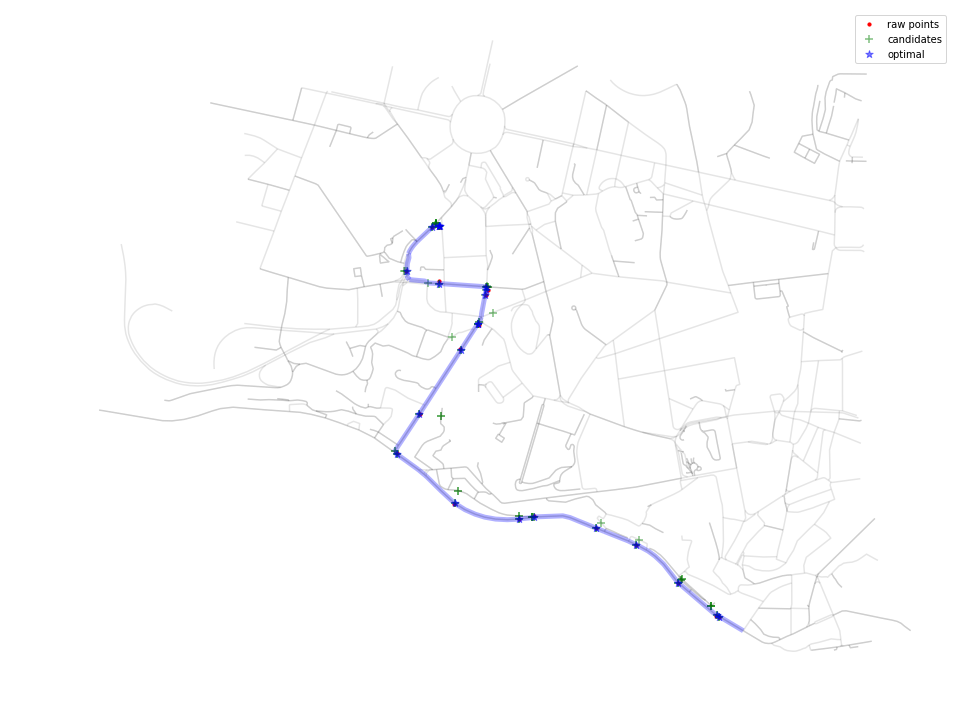

In [72]:
visualize_matching_results(trip, edge_idx, figname='matching_results_hmm_0.pdf')

In [73]:
trip['optimal candidate']

0     0
1     0
2     0
3     1
4     1
5     1
6     1
7     1
8     1
9     0
10    0
11    1
12    1
13    0
14    0
15    1
16    0
17    1
18    1
19    0
20    0
21    0
22    0
Name: optimal candidate, dtype: int64

In [53]:
trip['candidates'][22]

,distance,from,to,proj_point,road,observation prob
0,3.480954,129800102,129800097,POINT (530975.5678145927 4555976.022882612),from ...,0.037549
1,17.598716,129800102,129795309,POINT (530961.6449154677 4555984.711700277),from ...,0.008480
2,17.598716,129795309,129800102,POINT (530961.6449154677 4555984.711700277),from ...,0.008480


In [54]:
trip['weights'].iloc[2][0]

,from_id,to_id,sp distance,gc distance,sp edges,transition prob,weight_sum
0,0,0,197.981786,198.385498,"[[286969943, 1788784885, LINESTRING (532105.77...",0.009960,1.202069e-07
1,1,0,403.467119,198.385498,"[[1788784885, 286969943, LINESTRING (531904.63...",0.001286,1.757791e-08
2,2,0,198.526748,198.385498,"[[475564016, 2915001116, LINESTRING (531965.76...",0.009986,3.429080e-14
3,3,0,162.551578,198.385498,"[[2915001116, 475564016, LINESTRING (532000.40...",0.006988,1.674666e-14


In [22]:
from scipy import stats

In [63]:
stats.norm.pdf(3,0,1)

0.0044318484119380075

In [26]:
gpd_edges_utm.head(10)

,from,to,geometry,length,highway,bbox,max speed
0,296058885,1628753289,LINESTRING (531068.006566746 4558739.619749674...,155.377405,secondary,"(531068.006567, 4558592.64786, 531117.808982, ...",50
1,296058885,1561621045,LINESTRING (531068.006566746 4558739.619749674...,67.837805,primary,"(531068.006567, 4558739.61975, 531135.491049, ...",60
2,2185756687,435240914,LINESTRING (533863.3661556013 4558657.15794647...,260.154858,"[residential, service]","(533676.804891, 4558563.44126, 533863.366156, ...",30
3,2185756687,506111741,LINESTRING (533863.3661556013 4558657.15794647...,175.753043,service,"(533863.366156, 4558641.90652, 534038.822479, ...",20
4,299597866,299598639,LINESTRING (534689.3168561951 4558013.88137999...,54.764152,residential,"(534689.316856, 4558013.88138, 534723.50894, 4...",30
5,299597869,299607856,LINESTRING (534783.4474161046 4558218.89801132...,39.961953,secondary,"(534745.861676, 4558218.89801, 534783.447416, ...",50
6,299597869,122491913,LINESTRING (534783.4474161046 4558218.89801132...,66.391780,secondary,"(534783.447416, 4558195.75995, 534845.797904, ...",50
7,299597869,299598639,LINESTRING (534783.4474161046 4558218.89801132...,173.811754,residential,"(534723.50894, 4558055.98568, 534783.447416, 4...",30
8,480346169,480346202,LINESTRING (528276.1174898612 4555410.97583780...,65.943671,living_street,"(528276.11749, 4555366.0284, 528316.829885, 45...",20
9,480346169,1105954954,LINESTRING (528276.1174898612 4555410.97583780...,40.155331,residential,"(528266.399874, 4555372.07213, 528276.11749, 4...",30


In [32]:
print road_graph_utm[296058885][1628753289][0]['geometry']

LINESTRING (531068.006566746 4558739.619749674, 531072.6101126164 4558726.106584686, 531108.8354202011 4558617.943295655, 531117.8089815954 4558592.647864844)


In [33]:
print road_graph_utm[1628753289][296058885][0]['geometry']

LINESTRING (531117.8089815954 4558592.647864844, 531108.8354202011 4558617.943295655, 531072.6101126164 4558726.106584686, 531068.006566746 4558739.619749674)


In [44]:
import math

In [45]:
math.log(0.0001)

-9.210340371976182

In [46]:
math.log(0.001)

-6.907755278982137

In [66]:
trip.iloc[0]['candidates'].apply(lambda x: math.log(x['observation prob']), axis=1)

0    -3.346346
1    -3.346346
2   -11.796804
3   -11.796804
dtype: float64